In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers,callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import os
import cv2
import glob

2024-04-30 15:54:52.673470: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading Data

In [2]:
path = "input/Face Mask Dataset/"
os.listdir(path)

['.DS_Store', 'Test', 'Train', 'Validation']

In [3]:
image_path = []
label = []
location = []

for where in os.listdir(path):
    if where != ".DS_Store":  # Skip .DS_Store
        for status in os.listdir(os.path.join(path, where)):
            for image in glob.glob(os.path.join(path, where, status, "*.png")):
                image_path.append(image)
                label.append(status)
                location.append(where)
            
data = pd.DataFrame({'image_path':image_path,'label':label,'location':location})
data.head()

,image_path,label,location
0,input/Face Mask Dataset/Test/WithoutMask/2734.png,WithoutMask,Test
1,input/Face Mask Dataset/Test/WithoutMask/4345.png,WithoutMask,Test
2,input/Face Mask Dataset/Test/WithoutMask/4423.png,WithoutMask,Test
3,input/Face Mask Dataset/Test/WithoutMask/2052.png,WithoutMask,Test
4,input/Face Mask Dataset/Test/WithoutMask/3364.png,WithoutMask,Test


In [4]:
train_data =data[data['location']=='Train'].sample(frac=1)
test_data = data[data['location']=='Test'].sample(frac=1)
validation_data = data[data['location']=='Validation'].sample(frac=1) # .sample to shuffle the data

In [5]:
def plot_images(data):
    for loc in range(3):
        plt.imshow(cv2.imread(data.iloc[loc,0]))
        plt.title(f'{data.iloc[loc,2]}-{data.iloc[loc,1]}')
        plt.show()

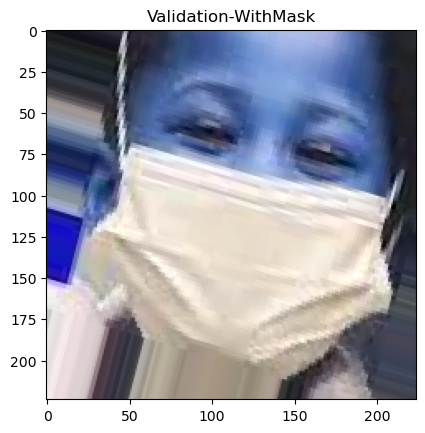

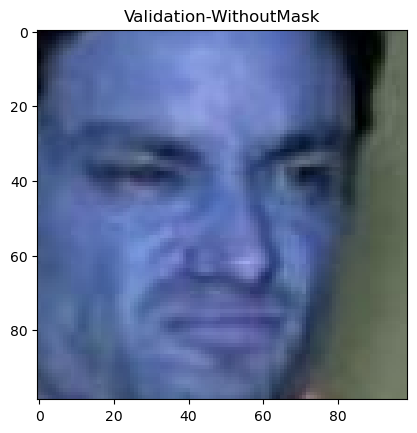

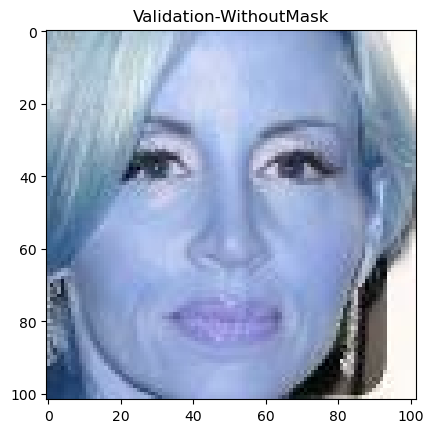

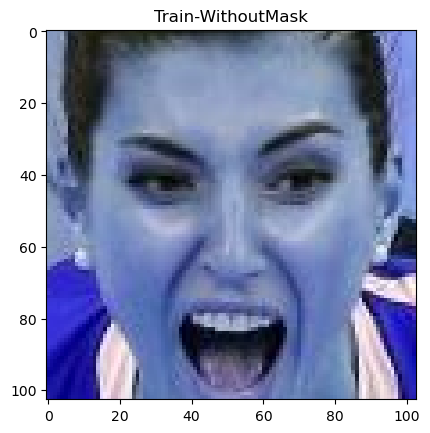

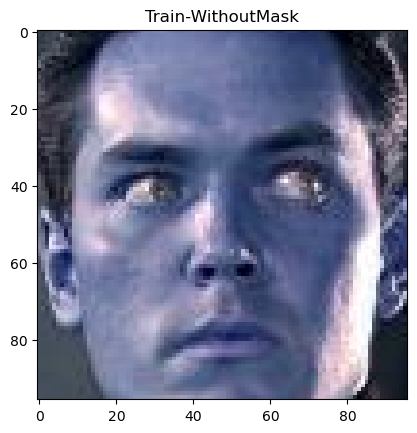

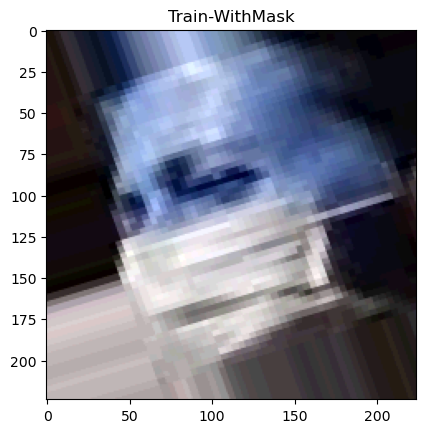

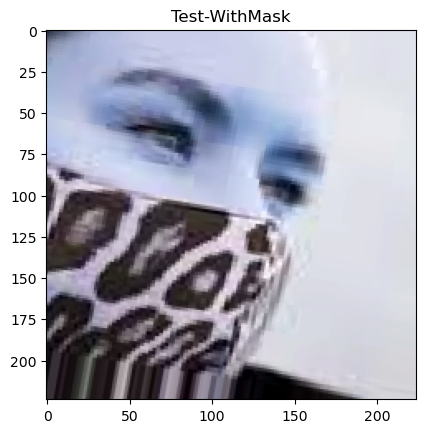

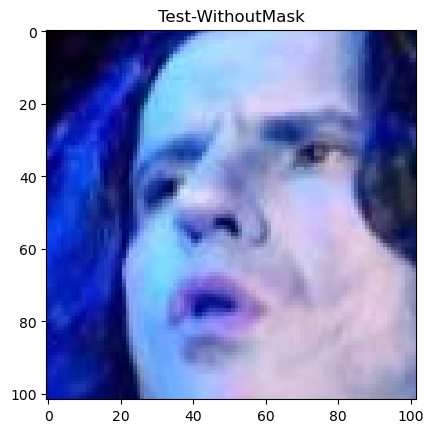

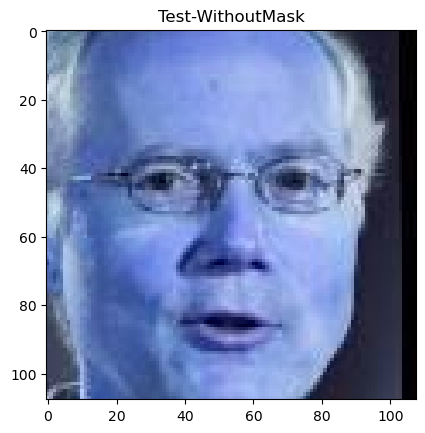

In [6]:
plot_images(validation_data)
plot_images(train_data)
plot_images(test_data)

In [7]:
def data_preprocessing(input_data, target_size=(150, 150)):
    input_data = input_data.reset_index().drop("index", axis=1)
    X = []
    y = []
    for i in range(len(input_data)):
        img_array = cv2.imread(input_data["image_path"][i], cv2.IMREAD_GRAYSCALE)
        new_image_array = cv2.resize(img_array, target_size)
        X.append(new_image_array)
        if input_data["label"][i] == "WithMask":
            y.append(1)
        else:
            y.append(0)
    X = np.array(X)
    X = X / 255.0  # Normalize pixel values
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)  # Reshape for CNN input
    y = np.array(y)
    return X, y

In [8]:
Train_data, Train_labels = data_preprocessing(train_data)
Validation_data, Validation_labels = data_preprocessing(validation_data)

In [9]:
Train_data.shape,Train_labels.shape

((10000, 150, 150, 1), (10000,))

## Building Model

In [10]:
model = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [11]:
#early_stopppings = callbacks.EarlyStopping(min_delta=0.001,patience=3,restore_best_weights=True)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [11]:
history = model.fit(Train_data,Train_labels,
                    validation_data=(Validation_data,Validation_labels),
                    batch_size = 45,
                    epochs=6)

Epoch 1/6
223/223 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - binary_accuracy: 0.8736 - loss: 2.0863 - val_binary_accuracy: 0.5000 - val_loss: 3.7609
Epoch 2/6
223/223 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - binary_accuracy: 0.9700 - loss: 0.2523 - val_binary_accuracy: 0.9463 - val_loss: 0.1116
Epoch 3/6
223/223 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - binary_accuracy: 0.9755 - loss: 0.1584 - val_binary_accuracy: 0.8600 - val_loss: 0.7560
Epoch 4/6
223/223 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - binary_accuracy: 0.9788 - loss: 0.1041 - val_binary_accuracy: 0.9800 - val_loss: 0.1136
Epoch 5/6
223/223 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - binary_accuracy: 0.9919 - loss: 0.0390 - val_binary_accuracy: 0.9563 - val_loss: 0.1312
Epoch 6/6
223/223 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - binary_accuracy: 0.9882 - loss: 0.0442 - val_binary_accuracy: 0.9038 - val_loss: 0.8365


In [12]:
# Save the model
model.save("model/facewmask_model_1.keras")

/var/folders/37/chdnsrl952z4r92vxgj50kcr0000gp/T/ipykernel_81010/1161518413.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.binary_accuracy, 'bo-', label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
/var/folders/37/chdnsrl952z4r92vxgj50kcr0000gp/T/ipykernel_81010/1161518413.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(data.binary_accuracy, 'bo-', label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
/var/folders/37/chdnsrl952z4r92vxgj50kcr0000gp/T/ipykernel_81010/1161518413.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "ro-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.val_binary_accuracy, '

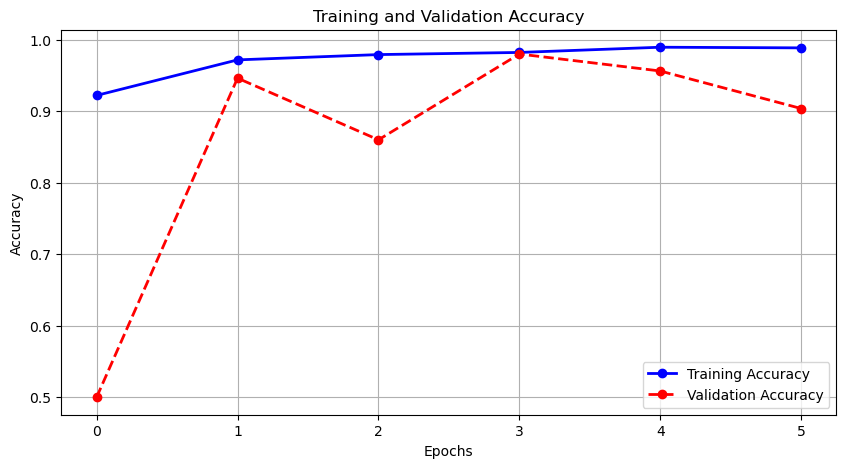

In [40]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(data.binary_accuracy, 'bo-', label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
plt.plot(data.val_binary_accuracy, 'ro-', label='Validation Accuracy', color='red', linestyle='--', linewidth=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/37/chdnsrl952z4r92vxgj50kcr0000gp/T/ipykernel_81010/2583141925.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.loss, 'bo-', label='Training Loss', color='blue', linestyle='-', linewidth=2)
/var/folders/37/chdnsrl952z4r92vxgj50kcr0000gp/T/ipykernel_81010/2583141925.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(data.loss, 'bo-', label='Training Loss', color='blue', linestyle='-', linewidth=2)
/var/folders/37/chdnsrl952z4r92vxgj50kcr0000gp/T/ipykernel_81010/2583141925.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "ro-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.val_loss, 'ro-', label='Validation Loss', color='red

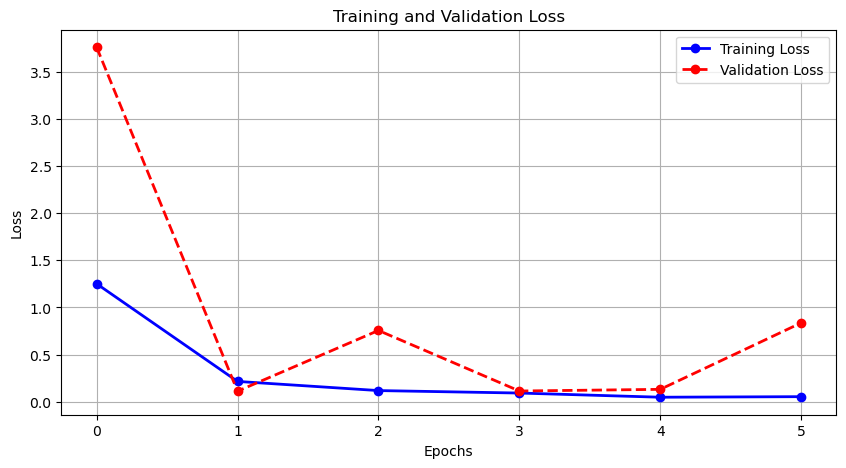

In [41]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(data.loss, 'bo-', label='Training Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(data.val_loss, 'ro-', label='Validation Loss', color='red', linestyle='--', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
data.head()

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.9221,1.251290,0.50000,3.760873
1,0.9718,0.215337,0.94625,0.111588
2,0.9792,0.118175,0.86000,0.755981
3,0.9822,0.091945,0.98000,0.113553
4,0.9895,0.047641,0.95625,0.131198


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 74, 74, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 17, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,940,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,933,829 (221.00 MB)

 Trainable params: 19,310,977 (73.67 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 38,621,956 (147.33 MB)

In [24]:
Test_data, Test_labels = data_preprocessing(test_data)

In [25]:
# Evaluate the model to get the loss and accuracy
test_loss, test_acc = model.evaluate(Test_data, Test_labels)
print('Test Accuracy:', test_acc)

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - binary_accuracy: 0.9135 - loss: 0.7453
Test Accuracy: 0.9163306355476379


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step


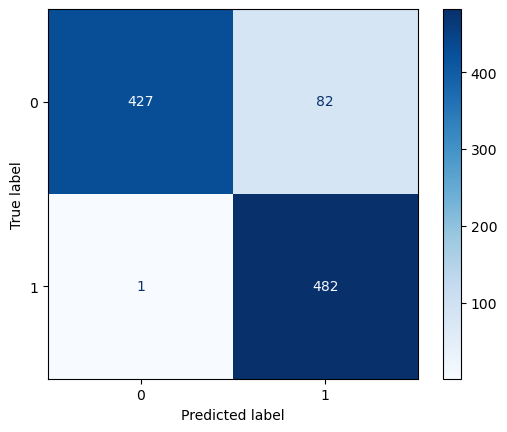

In [26]:
# Get predictions from the model
predicted_probs = model.predict(Test_data)
predicted_labels = (predicted_probs > 0.5).astype(int)  # Threshold probabilities to get binary labels

# Generate and plot the confusion matrix
cm = confusion_matrix(Test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


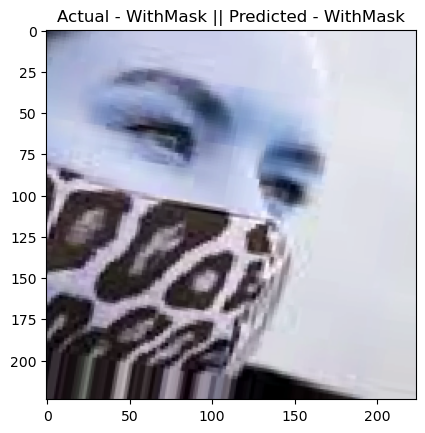

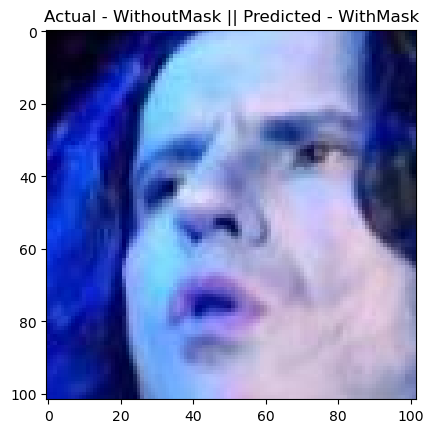

In [29]:
class_names = ['WithMask','WithoutMask'] 

def plot_images(data,predicted_labels):
    for loc in range(2):
        plt.imshow(cv2.imread(data.iloc[loc,0]))
        plt.title(f'Actual - {data.iloc[loc,1]} || Predicted - {class_names[np.argmax(predicted_labels[loc])]}')
        plt.show()
        
plot_images(test_data,predicted_labels)

## Model with Attention

In [33]:
from tensorflow.keras.layers import Layer, Conv2D, Dense, BatchNormalization, Activation
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, ratio=8):
        super(ChannelAttention, self).__init__()
        self.ratio = ratio

    def build(self, input_shape):
        self.shared_layer_one = Dense(input_shape[-1] // self.ratio,
                                      activation='relu',
                                      kernel_initializer='he_normal',
                                      use_bias=True,
                                      bias_initializer='zeros')
        self.shared_layer_two = Dense(input_shape[-1],
                                      kernel_initializer='he_normal',
                                      use_bias=True,
                                      bias_initializer='zeros')

    def call(self, input_tensor):
        avg_pool = K.mean(input_tensor, axis=(1, 2), keepdims=True)
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)

        max_pool = K.max(input_tensor, axis=(1, 2), keepdims=True)
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)

        scale = K.sigmoid(avg_pool + max_pool)
        return input_tensor * scale

class SpatialAttention(Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        if kernel_size % 2 == 0:
            raise ValueError('Kernel size must be odd.')
        self.conv1 = Conv2D(1,
                            kernel_size,
                            padding='same',
                            activation='sigmoid',
                            kernel_initializer='he_normal',
                            use_bias=False)

    def call(self, input_tensor):
        avg_pool = K.mean(input_tensor, axis=-1, keepdims=True)
        max_pool = K.max(input_tensor, axis=-1, keepdims=True)
        concat = K.concatenate([avg_pool, max_pool], axis=-1)
        scale = self.conv1(concat)
        return input_tensor * scale


In [34]:
model_1 = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    ChannelAttention(),
    SpatialAttention(),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    ChannelAttention(),
    SpatialAttention(),
    layers.Dropout(0.25),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    ChannelAttention(),
    SpatialAttention(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [35]:
history = model_1.fit(Train_data,Train_labels,
                    validation_data=(Validation_data,Validation_labels),
                    batch_size = 45,
                    epochs=6)

Epoch 1/6
223/223 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - binary_accuracy: 0.8807 - loss: 0.4211 - val_binary_accuracy: 0.5000 - val_loss: 1.9873
Epoch 2/6
223/223 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - binary_accuracy: 0.9736 - loss: 0.0733 - val_binary_accuracy: 0.6787 - val_loss: 0.9535
Epoch 3/6
223/223 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - binary_accuracy: 0.9821 - loss: 0.0474 - val_binary_accuracy: 0.8850 - val_loss: 0.2843
Epoch 4/6
223/223 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - binary_accuracy: 0.9904 - loss: 0.0272 - val_binary_accuracy: 0.8125 - val_loss: 0.4316
Epoch 5/6
223/223 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - binary_accuracy: 0.9893 - loss: 0.0324 - val_binary_accuracy: 0.9825 - val_loss: 0.0485
Epoch 6/6
223/223 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - binary_accuracy: 0.9928 - loss: 0.0205 - val_binary_accuracy: 0.9712 - val_loss: 0.0847


In [36]:
# Save the model
model_1.save("model/facewmask_model_2.keras")

/var/folders/37/chdnsrl952z4r92vxgj50kcr0000gp/T/ipykernel_81010/898294981.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
/var/folders/37/chdnsrl952z4r92vxgj50kcr0000gp/T/ipykernel_81010/898294981.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
/var/folders/37/chdnsrl952z4r92vxgj50kcr0000gp/T/ipykernel_81010/898294981.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "ro-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'ro-', label='Valid

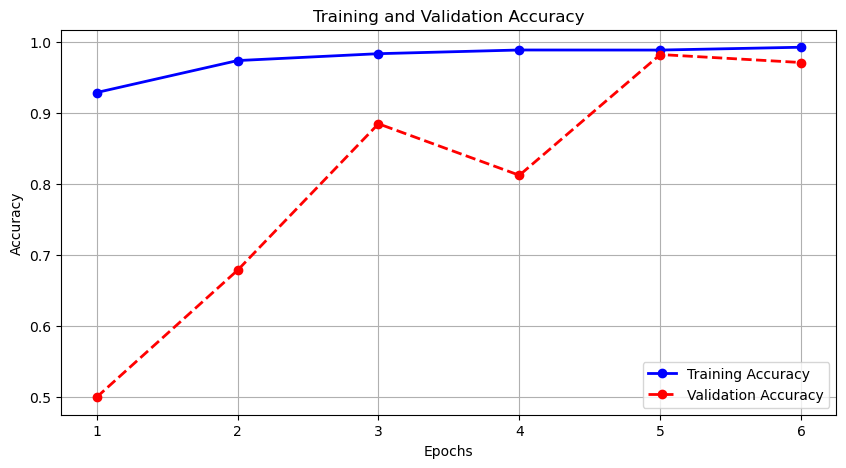

In [39]:
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy', color='red', linestyle='--', linewidth=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/37/chdnsrl952z4r92vxgj50kcr0000gp/T/ipykernel_81010/1796465342.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(epochs, train_loss, 'bo-', label='Training Loss', color='blue', linestyle='-', linewidth=2)
/var/folders/37/chdnsrl952z4r92vxgj50kcr0000gp/T/ipykernel_81010/1796465342.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, train_loss, 'bo-', label='Training Loss', color='blue', linestyle='-', linewidth=2)
/var/folders/37/chdnsrl952z4r92vxgj50kcr0000gp/T/ipykernel_81010/1796465342.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "ro-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'ro-', label='Validat

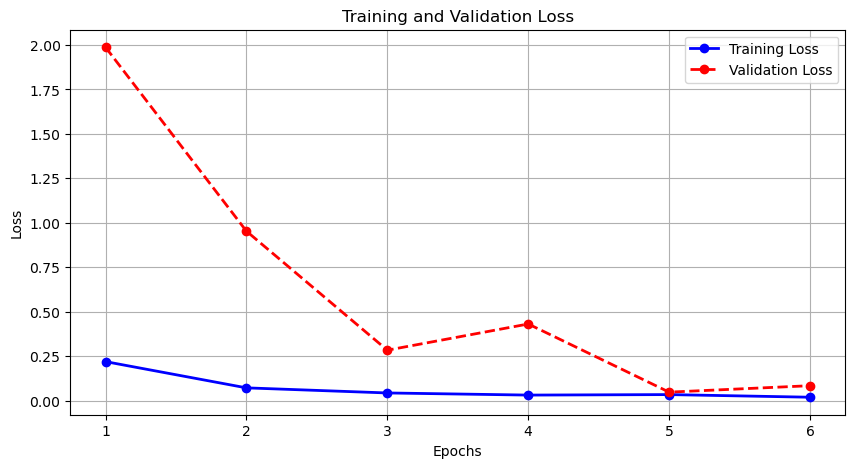

In [42]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss', color='red', linestyle='--', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Evaluate the model to get the loss and accuracy
test_loss, test_acc = model_1.evaluate(Test_data, Test_labels)
print('Test Accuracy:', test_acc)

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - binary_accuracy: 0.9710 - loss: 0.0906
Test Accuracy: 0.9637096524238586


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step


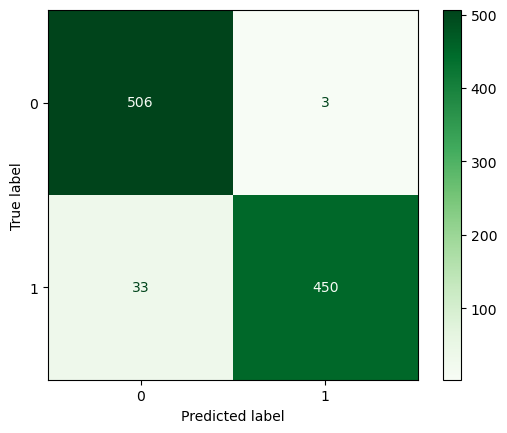

In [45]:
# Get predictions from the model
predicted_probs = model_1.predict(Test_data)
predicted_labels = (predicted_probs > 0.5).astype(int)  # Threshold probabilities to get binary labels

# Generate and plot the confusion matrix
cm = confusion_matrix(Test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.show()